# Constructing Social Networks in the Bible

### <i>Lemuel Kumarga</i>


## Problem Description

Our social circles are huge parts of our lives. They represent who we interact with, and how much we interact with them. With the digitization of communication and socialization, finding out this circle within each individual is an easier task than before. A simple glimpse into social networking sites such as Facebook and LinkedIn allows us to see who our friends are, whilst the frequency of digital communication can be used as a proxy of our closeness with them.

However, such information was not easily quantifiable in the pre-technology era. By attempting to model past lives using modern concepts, we could potentially gain further information about the past. For this project, we will use Natural Language Processing (NLP) concepts to <b>construct a social network for the bible, with the aim to depeen our understanding of the gospel.</b>


## Preliminaries

First load the necessary modules for this exercise.

In [117]:
import sys
sys.path.append('shared/')
from defaults import *

# Load All Main Modules
load({"pd":"pandas",
      "cl":"collections",
      "np":"numpy",
      "sp":"scipy",
      "mpl":"matplotlib",
      "nltk":"nltk"})

# Load All Submodules
from collections import OrderedDict

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
# If you can't find the module, run nltk.download() in python
from nltk import sent_tokenize, word_tokenize

defaults()

## Exploration

### Loading the Data

For this exercise, we will be using the bible <a data-toggle="popover" title="" data-content="A collection of texts" data-original-title="Corpus">corpus</a> from <a href="https://www.kaggle.com/oswinrh/bible/data">Kaggle.</a> The data will be stored in abbreviated book keys, with each book containing the following attributes:

* <span class="hl">Book Name</span>: Full name of the book
* <span class="hl">Testament</span>: New (NT) or old (OT)
* <span class="hl">Genre</span>: Genre of the book
* <span class="hl">Chapters</span>: Number of chapters
* <span class="hl">Verses</span>: Total number of verses
* <span class="hl">Text</span>: The actual text of the book



In [116]:
# Get all book statistics
abb = pd.read_csv("data/key_abbreviations_english.csv")\
        .query('p == 1')[["a","b"]]\
        .rename(columns={"a" : "Key"})
ot_nt = pd.read_csv("data/key_english.csv")\
          .rename(columns={"n" : "Name", "t" : "Testament"})
genres = pd.read_csv("data/key_genre_english.csv")\
           .rename(columns={"n" : "Genre"})
genres["Genre"] = genres["g"].map(str) + " " + genres["Genre"]

# Load the main biblical text
bible = pd.read_csv("data/t_asv.csv")\
          .groupby("b", as_index=False)\
          .agg({"c": pd.Series.nunique, "v": "size", "t":" ".join})\
          .rename(columns={"c": "Chapters","v": "Verses","t": "Text"})

# Join the remaining book statistics
bible = bible.join(abb.set_index('b'), on='b')\
             .join(ot_nt.set_index('b'), on='b')\
             .join(genres.set_index('g'), on='g')\
             .drop(['b', 'g'], axis=1)\
             .set_index('Key')\
             [["Name","Testament","Genre","Chapters","Verses","Text"]]
            
# Show the first few lines
bible.head(5)

,Name,Testament,Genre,Chapters,Verses,Text
Key,,,,,,
Gen,Genesis,OT,1 Law,50,1533,In the beginning God created the heavens and t...
Exo,Exodus,OT,1 Law,40,1213,"Now these are the names of the sons of Israel,..."
Lev,Leviticus,OT,1 Law,27,859,"And Jehovah called unto Moses, and spake unto ..."
Num,Numbers,OT,1 Law,36,1288,And Jehovah spake unto Moses in the wilderness...
Deut,Deuteronomy,OT,1 Law,34,959,These are the words which Moses spake unto all...



### About the Data

We will also derive some language statistics from each book, mainly:

* <span class="hl">Sentences</span>: Number of sentences in each book.
* <span class="hl">Words</span>: Number of words in each book.

In [124]:
# Add Sentences and Words columns
bible["Sentences"] = pd.Series(0, index=bible.index)
bible["Words"] = pd.Series(0, index=bible.index)

# Save Tokens
sent_tokens = OrderedDict()
word_tokens = OrderedDict()

for i, r in bible[["Text"]].iterrows():
    txt = r.str.cat()
    sent_tokens[i] = sent_tokenize(txt)
    word_tokens[i] = word_tokenize(txt)
    bible.at[i,'Sentences'] = len(sent_tokens[i])
    bible.at[i,'Words'] = len(word_tokens[i])

# Show
bible[["Name","Testament","Genre","Chapters","Verses","Sentences","Words"]].head(5)

,Name,Testament,Genre,Chapters,Verses,Sentences,Words
Key,,,,,,,
Gen,Genesis,OT,1 Law,50,1533,1756,44879
Exo,Exodus,OT,1 Law,40,1213,1116,37232
Lev,Leviticus,OT,1 Law,27,859,664,27278
Num,Numbers,OT,1 Law,36,1288,996,37053
Deut,Deuteronomy,OT,1 Law,34,959,745,32120


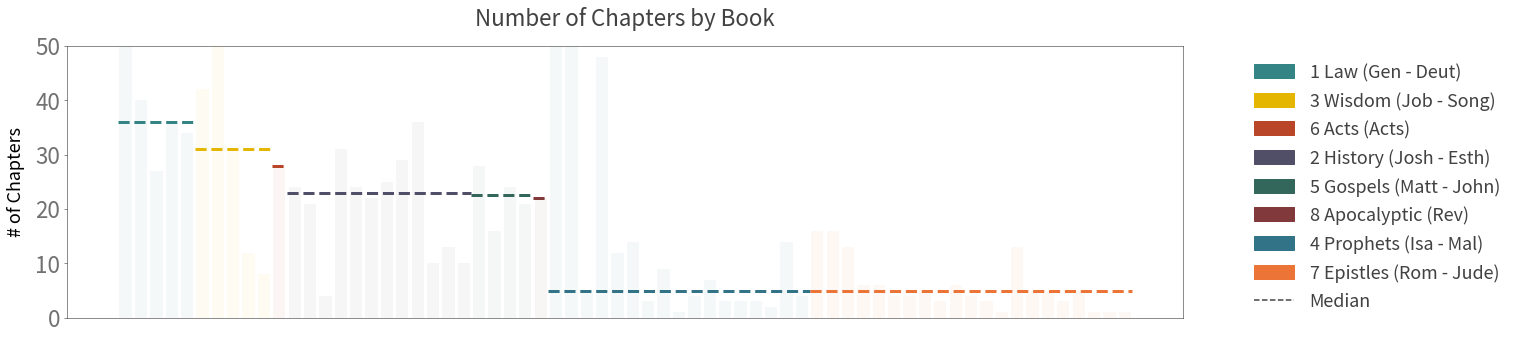

In [120]:
def plot_overview_stats(attribute, title, ylabel):

    groups = bible.groupby("Genre",sort=False)

    # Get Colors
    color_pal = get_color("palette")(len(groups))
    color_dict = { }
    ind = 0
    for name in groups.groups.keys():
        color_dict[name] = color_pal[ind]
        ind += 1
    
    plt.figure(figsize=(20,5))

    # Add Titles and Labels
    plt.title(title)
    plt.xticks([])
    plt.ylabel(ylabel)

    # Legend container
    ind = 0
    legends = []
    
    for name, group in sorted(groups, key=lambda g: np.median(g[1][attribute]), reverse=True):
        
        row_ids = list(range(ind, ind + len(group.index)))
        middle = np.median(group[attribute])
        
        # Plot the Bar Graphs
        plt.bar(row_ids,
                group[attribute],
                color= fade_color(color_dict[name],0.05))

        # Plot Average Lines
        plt.plot([min(row_ids) - 0.5, max(row_ids) + 0.5],
                 [middle, middle],
                 color = color_dict[name],
                 linestyle = "dashed",
                 linewidth = 3)

        # Configure Legends
        legend_text = name + " (" + group.index[0]
        if (len(group.index) > 1):
            legend_text += " - " + group.index[-1]
        legend_text += ")"
        legends.append(mpatches.Patch(color=color_dict[name], label=legend_text))
        ind += len(group.index)

    # Add Line Legend
    legends.append(mlines.Line2D([],[],color=txt_color, label='Median', linestyle ="dashed"))
    plt.legend(handles=legends, bbox_to_anchor=[1.3, 1.])

    
plot_overview_stats("Chapters", "Number of Chapters by Book", "# of Chapters")
plt.ylim(0,50)
plt.show()

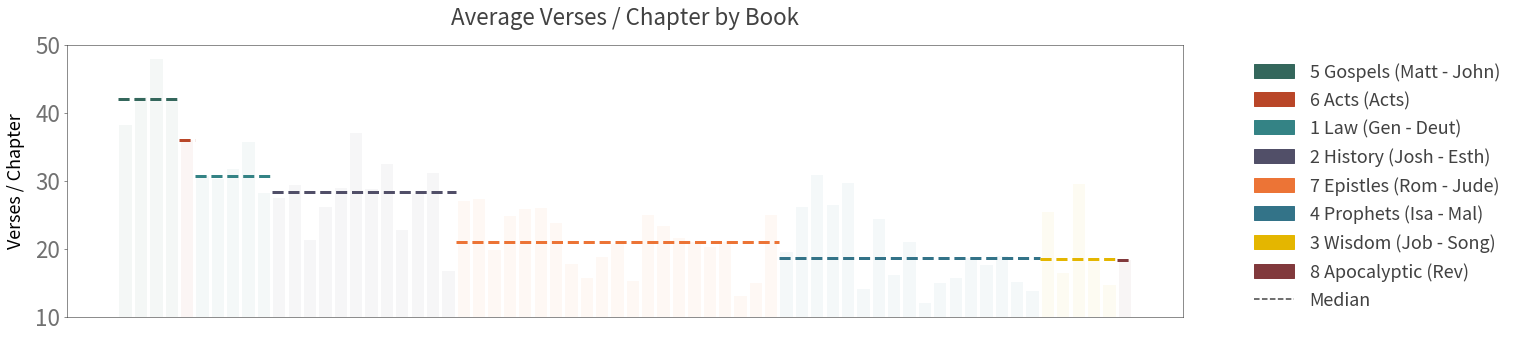

In [121]:
bible["Verses_p_Chapter"] = bible["Verses"] / bible["Chapters"]
plot_overview_stats("Verses_p_Chapter", "Average Verses / Chapter by Book", "Verses / Chapter")
plt.ylim(10,50)
plt.show()

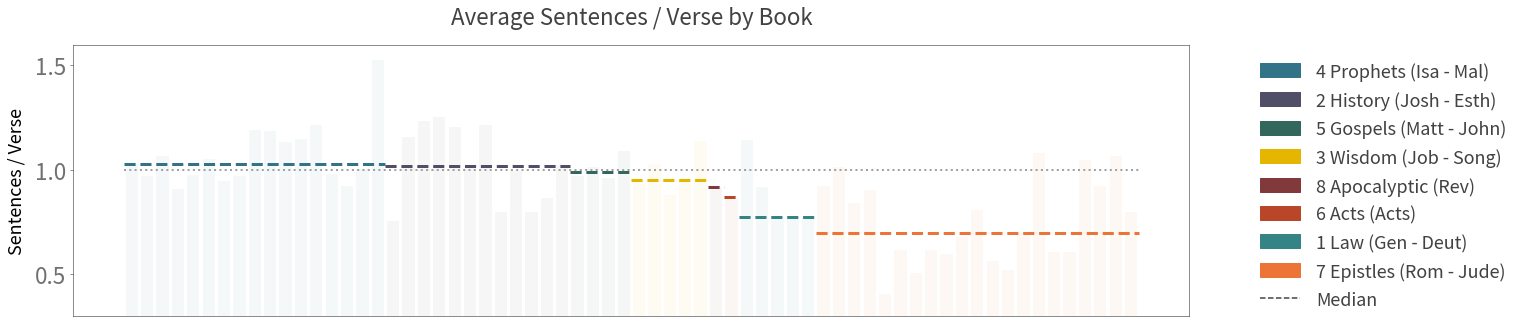

In [125]:
bible["Sentences_p_Verse"] = bible["Sentences"] / bible["Verses"]
plot_overview_stats("Sentences_p_Verse", "Average Sentences / Verse by Book", "Sentences / Verse")
plt.plot([0-0.5, len(bible.index)-0.5],
         [1, 1],
         color = fade_color(ltxt_color,0.5),
         linestyle = "dotted",
         linewidth = 2)
plt.ylim(0.3,1.6)
plt.show()

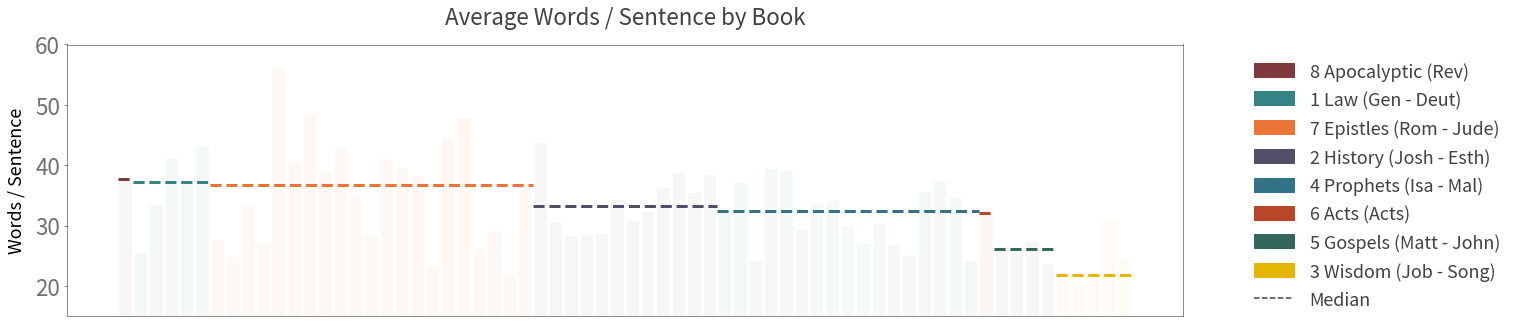

In [126]:
bible["Words_p_Sentence"] = bible["Words"] / bible["Sentences"]
plot_overview_stats("Words_p_Sentence", "Average Words / Sentence by Book", "Words / Sentence")
plt.ylim(15,60)
plt.show()





### Preliminary Insights

#### Faces of God

#### Major Characters

## Preparation

### Finding the Characters

### Cleaning Up the Errors

### Insights

## Constructing the Network

### Building Networks and Edges

### The Social Network

### Network Slices

## Summary of Results